<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number:
# Student 1: Denise La Gordt Dillie
# Student 2: Andreea Maican
# Student 3: Sambhav Jain

In case you are using google colab, uncomment the following cell, and modify the ```notebook_dir``` variable to contain the directory this notebook is in. It will automatically download the .py files needed for this assignment

In [1]:
# # Change the following  line to the directory this notebook is (if using colab)
# # In case you do not know the path, open the file navigator on the left in colab
# # Find the folder containing this notebook, then press on the three dots --> copy path
# notebook_dir = "/content/drive/MyDrive/Colab Notebooks/"

In [2]:
# # UNCOMMENT IF USING COLAB
# from google.colab import drive
# import requests
# drive.mount('/content/drive')
# import sys
# import os
# sys.path.insert(0, notebook_dir) 
# os.chdir(notebook_dir)
# symco = "https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/symconv.py?raw=true"
# crpt = "https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/carpet.py?raw=true"
# r_s = requests.get(symco, allow_redirects=True)
# r_c = requests.get(crpt, allow_redirects=True)
# with open('symconv.py', 'wb') as f:
#     f.write(r_s.content)
# with open('carpet.py', 'wb') as f:
#     f.write(r_c.content)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset

import io
import requests

import symconv as sc
from carpet import show_carpet, oh_to_label

import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist

from tqdm import tqdm

In [4]:
def load_numpy_arr_from_url(url):
    """
    Loads a numpy array from surfdrive. 
    
    Input:
    url: Download link of dataset 
    
    Outputs:
    dataset: numpy array with input features or labels
    """
    
    response = requests.get(url)
    response.raise_for_status()

    return np.load(io.BytesIO(response.content)) 

# Task 1: Pattern Classification

In [5]:
# loading training and testing data for task 1
# DO NOT MODIFY
task1 = load_numpy_arr_from_url("https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/task1data.npz?raw=true")
# task1 = np.load("task1data.npz")

X = torch.tensor(task1['arr_0']).float()
y = torch.tensor(task1['arr_1']).float()

X_train = X[:7500]
X_val = X[7500:9500]
X_test = X[9500:]
y_train = y[:7500]
y_val = y[7500:9500]
y_test  = y[9500:]


train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)


print(f"Carpet train shape: {X_train.shape}")
print(f"Label train shape: {y_train.shape}")
print(f"Carpet validation shape: {X_val.shape}")
print(f"Label validation shape: {y_val.shape}")
print(f"Carpet test shape: {X_test.shape}")
print(f"Label test shape: {y_test.shape}")

Carpet train shape: torch.Size([7500, 1, 96, 60])
Label train shape: torch.Size([7500, 3])
Carpet validation shape: torch.Size([2000, 1, 96, 60])
Label validation shape: torch.Size([2000, 3])
Carpet test shape: torch.Size([500, 1, 96, 60])
Label test shape: torch.Size([500, 3])


Carpet from Reinforciya


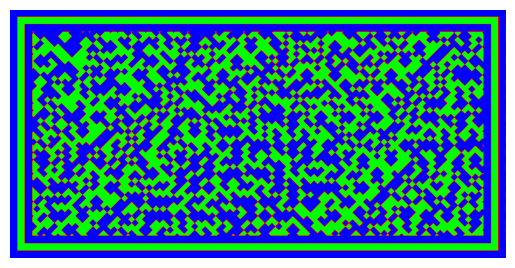

In [6]:
# random carpet
idx = np.random.randint(0,7500)
show_carpet(X_train, idx)
print('Carpet from', oh_to_label(y_train[idx,None])[0])

In [7]:
def loss_batch(model, loss_func, xb, yb, optimizer=None):
    yb = torch.argmax(yb, dim=1)

    assert yb.dim() <= 1, "Target tensor must have 0 or 1 dimensions"
    assert yb.numel() == len(xb), "Target tensor size must match input size"

    output = model(xb)
    loss = loss_func(output, yb.long())

    if optimizer is not None:
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    _, preds = torch.max(output, 1)
    corrects = torch.sum(preds == yb.long())

    return loss.item(), corrects, len(xb)

In [8]:
import matplotlib.pyplot as plt

def fit(epochs, model, loss_func, optimizer, train_dl, valid_dl, test_dl):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    test_losses = []
    test_accs = []

    for epoch in tqdm(range(epochs)):
        # Training process
        model.train()
        running_loss = 0.0
        running_corrects = 0
        sample_num = 0

        for xb, yb in train_dl:
            losses, corrects, nums = loss_batch(model, loss_func, xb, yb, optimizer)
            running_loss += losses * xb.size(0)
            running_corrects += corrects
            sample_num += nums

        train_loss = running_loss / sample_num
        train_acc = running_corrects.double() / sample_num

        # Validation process
        model.eval()
        with torch.no_grad():
            running_loss = 0.0
            running_corrects = 0
            sample_num = 0

            for xb, yb in valid_dl:
                losses, corrects, nums = loss_batch(model, loss_func, xb, yb)
                running_loss += losses * xb.size(0)
                running_corrects += corrects
                sample_num += nums

            val_loss = running_loss / sample_num
            val_acc = running_corrects.double() / sample_num

        # Testing process
        model.eval()
        with torch.no_grad():
            running_loss = 0.0
            running_corrects = 0
            sample_num = 0

            for xb, yb in test_dl:
                losses, corrects, nums = loss_batch(model, loss_func, xb, yb)
                running_loss += losses * xb.size(0)
                running_corrects += corrects
                sample_num += nums

            test_loss = running_loss / sample_num
            test_acc = running_corrects.double() / sample_num

        # Print the results
        print(f'EPOCH: {epoch+1:0>{len(str(epochs))}}/{epochs}', end=' ')
        print(f'LOSS: {train_loss:.4f}', f'ACC: {train_acc:.4f} ', end=' ')
        print(f'VAL-LOSS: {val_loss:.4f}', f'VAL-ACC: {val_acc:.4f} ', end=' ')
        print(f'TEST-LOSS: {test_loss:.4f}', f'TEST-ACC: {test_acc:.4f} ', end='\n')

        # Save losses and accuracies
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

    # Plot losses and accuracies
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, epochs+1), train_losses, 'r:', label='Train Loss')
    plt.plot(range(1, epochs+1), val_losses, 'g:', label='Validation Loss')
    plt.plot(range(1, epochs+1), test_losses, 'b:', label='Test Loss')
    plt.plot(range(1, epochs+1), train_accs, 'r', label='Train Accuracy')
    plt.plot(range(1, epochs+1), val_accs, 'g', label='Validation Accuracy')
    plt.plot(range(1, epochs+1), test_accs, 'b', label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss / Accuracy')
    plt.title('Loss and Accuracy vs. Epochs')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [9]:
def get_data(train_ds, valid_ds, batch_size):
    return (
        DataLoader(train_ds, batch_size=batch_size, shuffle=True),
        DataLoader(valid_ds, batch_size=batch_size * 2),
    )

In [10]:
batch_size = 32
train_dl, valid_dl = get_data(train_dataset, val_dataset, batch_size)
test_dl = DataLoader(test_dataset, batch_size=batch_size * 2)

In [11]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

In [40]:
model = nn.Sequential(
    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(1, 16, kernel_size=4, stride=4, rotation=4, reflection=False),
    nn.ReLU(inplace=True),
    sc.SymmetryPool(),
    nn.BatchNorm2d(16),
    nn.Dropout(p=0.08),
    nn.Conv2d(16, 32, kernel_size=3, stride=3),
    nn.ReLU(inplace=True),
    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(32, 10, kernel_size=5, stride=1, rotation=4, reflection=False),
    nn.ReLU(inplace=True),
    sc.SymmetryPool(),
    nn.BatchNorm2d(10),
    nn.Dropout(p=0.08),
    Lambda(lambda x: x.view(x.size(0), -1)),
    nn.Linear(40, 3),
    nn.ReLU(inplace=True),
)

# model = nn.Sequential(
#     sc.Slice(rotation=4, reflection=True),
#     sc.SymmetryConv2d(1, 32, kernel_size=4, stride=4, rotation=4, reflection=True),  # 4 * 4
#     nn.ReLU(inplace=True),
#     sc.SymmetryPool(),
#     nn.BatchNorm2d(32),
#     sc.Slice(rotation=4, reflection=True),
#     sc.SymmetryConv2d(32, 64, kernel_size=3, stride=3, rotation=4, reflection=True),   # 3 * 3 
#     nn.ReLU(inplace=True),  
#     sc.SymmetryPool(),
#     sc.Slice(rotation=4, reflection=True),
#     sc.SymmetryConv2d(64, 10, kernel_size=5, stride=1, rotation=4, reflection=True), # 8 * 5
#     nn.ReLU(inplace=True),
#     sc.SymmetryPool(),
#     nn.BatchNorm2d(10),
#     Lambda(lambda x: x.view(x.size(0), -1)),
#     nn.Linear(40, 3),
#     nn.ReLU(inplace=True),
# )

 10%|█         | 1/10 [00:07<01:03,  7.03s/it]

EPOCH: 01/10 LOSS: 1.0835 ACC: 0.4041  VAL-LOSS: 1.0001 VAL-ACC: 0.5075  TEST-LOSS: 0.9831 TEST-ACC: 0.5020 


 20%|██        | 2/10 [00:14<00:56,  7.09s/it]

EPOCH: 02/10 LOSS: 0.7470 ACC: 0.6605  VAL-LOSS: 0.3385 VAL-ACC: 0.8605  TEST-LOSS: 0.3461 TEST-ACC: 0.8580 


 30%|███       | 3/10 [00:21<00:50,  7.16s/it]

EPOCH: 03/10 LOSS: 0.3129 ACC: 0.8753  VAL-LOSS: 0.1759 VAL-ACC: 0.9295  TEST-LOSS: 0.1834 TEST-ACC: 0.9320 


 40%|████      | 4/10 [00:28<00:43,  7.17s/it]

EPOCH: 04/10 LOSS: 0.1993 ACC: 0.9239  VAL-LOSS: 0.1193 VAL-ACC: 0.9555  TEST-LOSS: 0.1449 TEST-ACC: 0.9460 


 50%|█████     | 5/10 [00:35<00:35,  7.10s/it]

EPOCH: 05/10 LOSS: 0.1579 ACC: 0.9419  VAL-LOSS: 0.0920 VAL-ACC: 0.9685  TEST-LOSS: 0.1013 TEST-ACC: 0.9680 


 60%|██████    | 6/10 [00:42<00:28,  7.06s/it]

EPOCH: 06/10 LOSS: 0.1238 ACC: 0.9505  VAL-LOSS: 0.4884 VAL-ACC: 0.8355  TEST-LOSS: 0.4987 TEST-ACC: 0.8300 


 70%|███████   | 7/10 [00:49<00:21,  7.05s/it]

EPOCH: 07/10 LOSS: 0.1859 ACC: 0.9287  VAL-LOSS: 0.0686 VAL-ACC: 0.9770  TEST-LOSS: 0.0941 TEST-ACC: 0.9680 


 80%|████████  | 8/10 [00:56<00:14,  7.07s/it]

EPOCH: 08/10 LOSS: 0.1165 ACC: 0.9583  VAL-LOSS: 0.2062 VAL-ACC: 0.9350  TEST-LOSS: 0.2505 TEST-ACC: 0.9200 


 90%|█████████ | 9/10 [01:03<00:07,  7.09s/it]

EPOCH: 09/10 LOSS: 0.0974 ACC: 0.9641  VAL-LOSS: 0.1017 VAL-ACC: 0.9645  TEST-LOSS: 0.1147 TEST-ACC: 0.9580 


100%|██████████| 10/10 [01:11<00:00,  7.11s/it]

EPOCH: 10/10 LOSS: 0.1279 ACC: 0.9539  VAL-LOSS: 0.2049 VAL-ACC: 0.9380  TEST-LOSS: 0.2492 TEST-ACC: 0.9160 


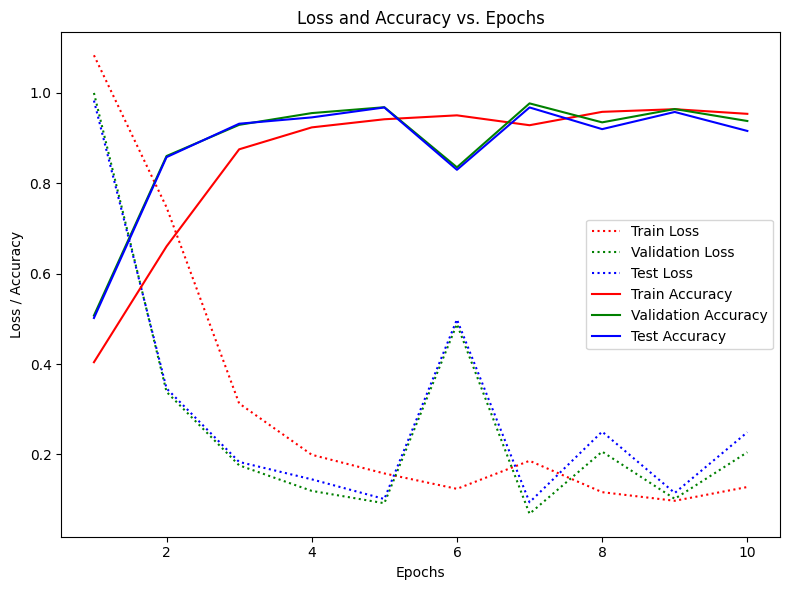

In [41]:
from torch import optim

lr = 0.1
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
epochs = 10
loss_func = F.cross_entropy

fit(epochs, model, loss_func, optimizer, train_dl, valid_dl, test_dl)

## Task 1: Question 5d

### Experiment 1
In this experiment, we change the number of convolutional filters in the model architecture. Convolutional filters are responsible for capturing different patterns and features from the input data. By altering the number of filters, we can assess the effect on the model's performance.

 10%|█         | 1/10 [00:07<01:10,  7.78s/it]

EPOCH: 01/10 LOSS: 1.0994 ACC: 0.5316  VAL-LOSS: 0.5154 VAL-ACC: 0.7910  TEST-LOSS: 0.4954 TEST-ACC: 0.8040 


 20%|██        | 2/10 [00:15<01:02,  7.85s/it]

EPOCH: 02/10 LOSS: 0.3859 ACC: 0.8525  VAL-LOSS: 0.2539 VAL-ACC: 0.9120  TEST-LOSS: 0.2573 TEST-ACC: 0.9060 


 30%|███       | 3/10 [00:23<00:54,  7.76s/it]

EPOCH: 03/10 LOSS: 0.2489 ACC: 0.9055  VAL-LOSS: 0.1849 VAL-ACC: 0.9290  TEST-LOSS: 0.1960 TEST-ACC: 0.9300 


 40%|████      | 4/10 [00:31<00:46,  7.73s/it]

EPOCH: 04/10 LOSS: 0.1976 ACC: 0.9247  VAL-LOSS: 0.1145 VAL-ACC: 0.9630  TEST-LOSS: 0.1233 TEST-ACC: 0.9580 


 50%|█████     | 5/10 [00:38<00:38,  7.68s/it]

EPOCH: 05/10 LOSS: 0.1597 ACC: 0.9396  VAL-LOSS: 0.2131 VAL-ACC: 0.9185  TEST-LOSS: 0.3077 TEST-ACC: 0.9020 


 60%|██████    | 6/10 [00:46<00:30,  7.68s/it]

EPOCH: 06/10 LOSS: 0.1355 ACC: 0.9503  VAL-LOSS: 0.1189 VAL-ACC: 0.9575  TEST-LOSS: 0.1719 TEST-ACC: 0.9300 


 70%|███████   | 7/10 [00:54<00:23,  7.74s/it]

EPOCH: 07/10 LOSS: 0.1195 ACC: 0.9589  VAL-LOSS: 0.1736 VAL-ACC: 0.9330  TEST-LOSS: 0.1803 TEST-ACC: 0.9320 


 80%|████████  | 8/10 [01:02<00:15,  7.80s/it]

EPOCH: 08/10 LOSS: 0.1018 ACC: 0.9636  VAL-LOSS: 0.0526 VAL-ACC: 0.9825  TEST-LOSS: 0.0910 TEST-ACC: 0.9620 


 90%|█████████ | 9/10 [01:10<00:07,  7.87s/it]

EPOCH: 09/10 LOSS: 0.0882 ACC: 0.9677  VAL-LOSS: 0.0649 VAL-ACC: 0.9790  TEST-LOSS: 0.1132 TEST-ACC: 0.9520 


100%|██████████| 10/10 [01:18<00:00,  7.81s/it]

EPOCH: 10/10 LOSS: 0.0830 ACC: 0.9708  VAL-LOSS: 0.0422 VAL-ACC: 0.9845  TEST-LOSS: 0.0745 TEST-ACC: 0.9680 


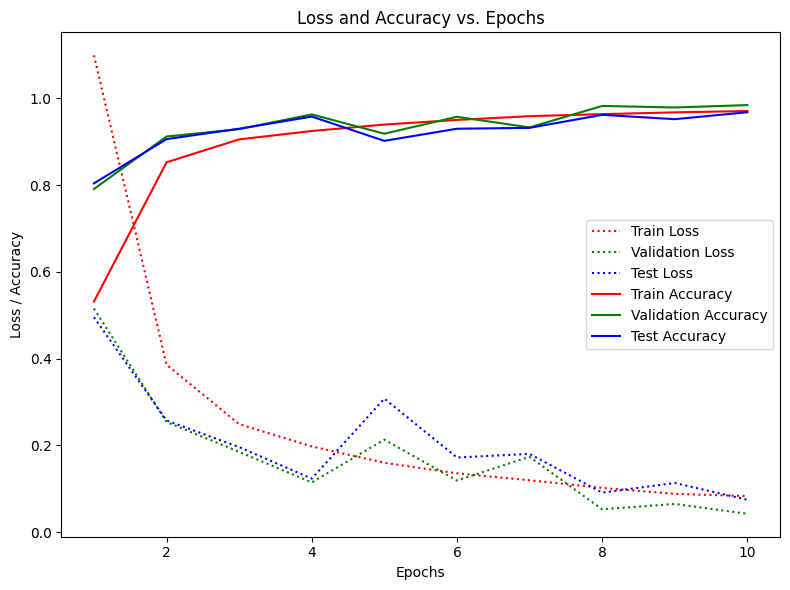

In [35]:
# Experiment 1: Change the Number of Convolutional Filters
# model_exp1 = nn.Sequential(
#     sc.Slice(rotation=4, reflection=False),
#     sc.SymmetryConv2d(1, 16, kernel_size=4, stride=4, rotation=4, reflection=False),  # Change the number of filters to 16
#     nn.ReLU(inplace=True),
#     sc.SymmetryPool(),
#     nn.BatchNorm2d(16),  # Adjust the batch normalization layer accordingly
#     nn.Conv2d(16, 64, kernel_size=3, stride=3),
#     nn.ReLU(inplace=True),
#     sc.Slice(rotation=4, reflection=False),
#     sc.SymmetryConv2d(64, 10, kernel_size=5, stride=1, rotation=4, reflection=False),
#     nn.ReLU(inplace=True),
#     sc.SymmetryPool(),
#     nn.BatchNorm2d(10),
#     Lambda(lambda x: x.view(x.size(0), -1)),
#     nn.Linear(40, 100),
#     nn.ReLU(inplace=True),
# )

model_exp1 = nn.Sequential(
    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(1, 16, kernel_size=4, stride=4, rotation=4, reflection=False),  # Change the number of filters to 16
    nn.ReLU(inplace=True),
    sc.SymmetryPool(),
    nn.BatchNorm2d(16),  # Adjust the batch normalization layer accordingly
    nn.Dropout(p=0.2),  # Add dropout layer with dropout probability of 0.2
    nn.Conv2d(16, 64, kernel_size=3, stride=3),
    nn.ReLU(inplace=True),
    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(64, 10, kernel_size=5, stride=1, rotation=4, reflection=False),
    nn.ReLU(inplace=True),
    sc.SymmetryPool(),
    nn.BatchNorm2d(10),
    Lambda(lambda x: x.view(x.size(0), -1)),
    nn.Dropout(p=0.2),  # Add dropout layer with dropout probability of 0.2
    nn.Linear(40, 100),
    nn.ReLU(inplace=True),
)


optimizer_exp1 = optim.Adagrad(model_exp1.parameters(), lr=lr)

fit(epochs, model_exp1, loss_func, optimizer_exp1, train_dl, valid_dl, test_dl)

### Experiment 2
In this experiment, we change the activation function used in the model architecture. The activation function introduces non-linearity to the model, allowing it to learn complex patterns and make non-linear predictions. By altering the activation function, we can assess its effect on the model's performance.

 10%|█         | 1/10 [00:08<01:15,  8.33s/it]

EPOCH: 01/10 LOSS: 1.5187 ACC: 0.3792  VAL-LOSS: 0.9027 VAL-ACC: 0.5640  TEST-LOSS: 0.8861 TEST-ACC: 0.5860 


 20%|██        | 2/10 [00:15<01:02,  7.87s/it]

EPOCH: 02/10 LOSS: 0.5800 ACC: 0.7503  VAL-LOSS: 0.3561 VAL-ACC: 0.8600  TEST-LOSS: 0.3251 TEST-ACC: 0.8580 


 30%|███       | 3/10 [00:23<00:53,  7.61s/it]

EPOCH: 03/10 LOSS: 0.2067 ACC: 0.9204  VAL-LOSS: 0.1298 VAL-ACC: 0.9520  TEST-LOSS: 0.1041 TEST-ACC: 0.9560 


 40%|████      | 4/10 [00:30<00:45,  7.59s/it]

EPOCH: 04/10 LOSS: 0.1027 ACC: 0.9627  VAL-LOSS: 0.1436 VAL-ACC: 0.9470  TEST-LOSS: 0.1030 TEST-ACC: 0.9760 


 50%|█████     | 5/10 [00:38<00:39,  7.82s/it]

EPOCH: 05/10 LOSS: 0.0956 ACC: 0.9656  VAL-LOSS: 0.0761 VAL-ACC: 0.9765  TEST-LOSS: 0.0718 TEST-ACC: 0.9740 


 60%|██████    | 6/10 [00:46<00:30,  7.70s/it]

EPOCH: 06/10 LOSS: 0.0531 ACC: 0.9808  VAL-LOSS: 0.0744 VAL-ACC: 0.9690  TEST-LOSS: 0.0652 TEST-ACC: 0.9820 


 70%|███████   | 7/10 [00:53<00:22,  7.46s/it]

EPOCH: 07/10 LOSS: 0.0455 ACC: 0.9845  VAL-LOSS: 0.0687 VAL-ACC: 0.9750  TEST-LOSS: 0.0678 TEST-ACC: 0.9740 


 80%|████████  | 8/10 [01:00<00:14,  7.30s/it]

EPOCH: 08/10 LOSS: 0.0379 ACC: 0.9871  VAL-LOSS: 0.0510 VAL-ACC: 0.9810  TEST-LOSS: 0.0282 TEST-ACC: 0.9900 


 90%|█████████ | 9/10 [01:07<00:07,  7.28s/it]

EPOCH: 09/10 LOSS: 0.0526 ACC: 0.9820  VAL-LOSS: 0.0402 VAL-ACC: 0.9855  TEST-LOSS: 0.0185 TEST-ACC: 0.9900 


100%|██████████| 10/10 [01:14<00:00,  7.46s/it]

EPOCH: 10/10 LOSS: 0.0361 ACC: 0.9883  VAL-LOSS: 0.1342 VAL-ACC: 0.9620  TEST-LOSS: 0.1767 TEST-ACC: 0.9580 


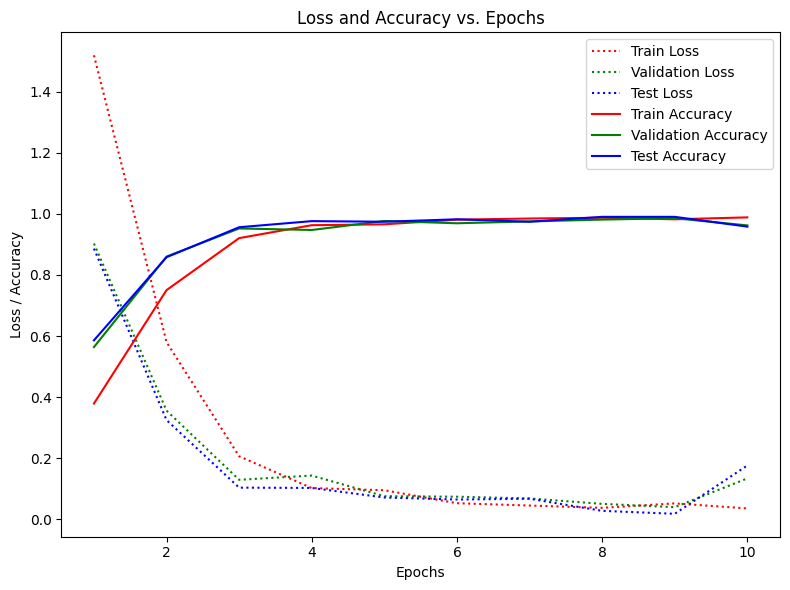

In [33]:
# Experiment 2: Change Activation Function
model_exp2 = nn.Sequential(
    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(1, 16, kernel_size=4, stride=4, rotation=4, reflection=False),
    nn.LeakyReLU(inplace=True),  # Change activation function
    sc.SymmetryPool(),
    nn.BatchNorm2d(16),
    nn.Conv2d(16, 32, kernel_size=3, stride=3),
    nn.LeakyReLU(inplace=True),  # Change activation function
    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(32, 10, kernel_size=5, stride=1, rotation=4, reflection=False),
    nn.LeakyReLU(inplace=True),  # Change activation function
    sc.SymmetryPool(),
    nn.BatchNorm2d(10),
    Lambda(lambda x: x.view(x.size(0), -1)),
    nn.Linear(40, 100),
    nn.LeakyReLU(inplace=True),  # Change activation function
)

optimizer_exp2 = optim.SGD(model_exp2.parameters(), lr=lr, momentum=0.9)

fit(epochs, model_exp2, loss_func, optimizer_exp2, train_dl, valid_dl, test_dl)

### Experiment 3
In this experiment, we change the learning rate used for training the model. The learning rate determines the step size at which the model updates its parameters during the optimization process. By adjusting the learning rate, we can explore its effect on the convergence speed and the overall performance of the model.

 10%|█         | 1/10 [00:12<01:52, 12.51s/it]

EPOCH: 01/10 LOSS: 2.7879 ACC: 0.3452  VAL-LOSS: 1.0549 VAL-ACC: 0.4830  TEST-LOSS: 1.0326 TEST-ACC: 0.4960 


 20%|██        | 2/10 [00:24<01:36, 12.02s/it]

EPOCH: 02/10 LOSS: 0.8716 ACC: 0.6021  VAL-LOSS: 0.7854 VAL-ACC: 0.6535  TEST-LOSS: 0.7210 TEST-ACC: 0.7040 


 30%|███       | 3/10 [00:35<01:20, 11.53s/it]

EPOCH: 03/10 LOSS: 0.6244 ACC: 0.7352  VAL-LOSS: 0.6119 VAL-ACC: 0.7440  TEST-LOSS: 0.5587 TEST-ACC: 0.7720 


 40%|████      | 4/10 [00:46<01:08, 11.34s/it]

EPOCH: 04/10 LOSS: 0.4536 ACC: 0.8209  VAL-LOSS: 0.5161 VAL-ACC: 0.7865  TEST-LOSS: 0.4975 TEST-ACC: 0.7940 


 50%|█████     | 5/10 [00:57<00:56, 11.32s/it]

EPOCH: 05/10 LOSS: 0.3388 ACC: 0.8689  VAL-LOSS: 0.4871 VAL-ACC: 0.8065  TEST-LOSS: 0.4536 TEST-ACC: 0.8080 


 60%|██████    | 6/10 [01:08<00:45, 11.27s/it]

EPOCH: 06/10 LOSS: 0.2579 ACC: 0.9079  VAL-LOSS: 0.4647 VAL-ACC: 0.8240  TEST-LOSS: 0.4259 TEST-ACC: 0.8320 


 70%|███████   | 7/10 [01:19<00:33, 11.27s/it]

EPOCH: 07/10 LOSS: 0.1981 ACC: 0.9272  VAL-LOSS: 0.4420 VAL-ACC: 0.8380  TEST-LOSS: 0.3949 TEST-ACC: 0.8360 


 80%|████████  | 8/10 [01:32<00:23, 11.65s/it]

EPOCH: 08/10 LOSS: 0.1507 ACC: 0.9480  VAL-LOSS: 0.4290 VAL-ACC: 0.8495  TEST-LOSS: 0.3628 TEST-ACC: 0.8520 


 90%|█████████ | 9/10 [01:45<00:12, 12.25s/it]

EPOCH: 09/10 LOSS: 0.1173 ACC: 0.9599  VAL-LOSS: 0.4457 VAL-ACC: 0.8530  TEST-LOSS: 0.3572 TEST-ACC: 0.8560 


100%|██████████| 10/10 [01:59<00:00, 11.91s/it]

EPOCH: 10/10 LOSS: 0.0921 ACC: 0.9716  VAL-LOSS: 0.4446 VAL-ACC: 0.8515  TEST-LOSS: 0.3688 TEST-ACC: 0.8440 


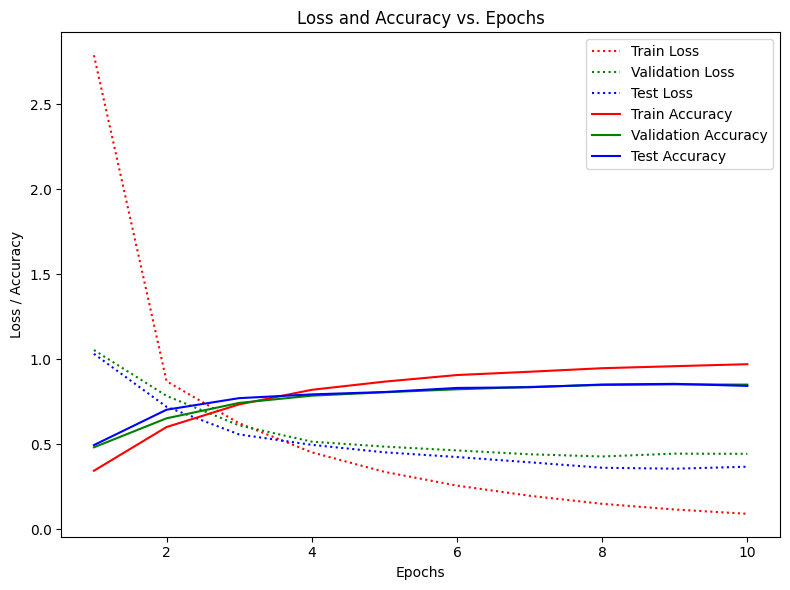

In [26]:
# Experiment 3: Adjust Learning Rate
lr_exp3 = 0.01  # Change learning rate

model_exp3 = nn.Sequential(
    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(1, 32, kernel_size=4, stride=4, rotation=4, reflection=False),
    nn.ReLU(inplace=True),
    sc.SymmetryPool(),
    nn.BatchNorm2d(32),
    nn.Conv2d(32, 64, kernel_size=3, stride=3),
    nn.ReLU(inplace=True),
    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(64, 10, kernel_size=5, stride=1, rotation=4, reflection=False),
    nn.ReLU(inplace=True),
    sc.SymmetryPool(),
    nn.BatchNorm2d(10),
    Lambda(lambda x: x.view(x.size(0), -1)),
    nn.Linear(40, 100),
    nn.ReLU(inplace=True),
)

optimizer_exp3 = optim.SGD(model_exp3.parameters(), lr=lr_exp3, momentum=0.9)

fit(epochs, model_exp3, loss_func, optimizer_exp3, train_dl, valid_dl, test_dl)

# Task 2: Carpet Matching 

In [ ]:
# loading training and testing data for task 2
# DO NOT MODIFY
task2 = load_numpy_arr_from_url("https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/task2data.npz?raw=true")
# task2 = np.load('task2data.npz')

X = task2['arr_0'].astype(float)
y = task2['arr_1'].astype(float)
gt = task2['arr_2'].astype(float) # ground truth
queries = task2['arr_3'].astype(float)
targets = task2['arr_4'].astype(float)

print(f"Carpet train shape: {X.shape}")
print(f"Label train shape: {y.shape}")
print(f"Ground truth test shape: {gt.shape}")
print(f"Query carpets shape: {queries.shape}")
print(f"Candidate carpets shape: {targets.shape}")

Carpet train shape: (15000, 1, 96, 60)
Label train shape: (15000,)
Ground truth test shape: (300,)
Query carpets shape: (300, 1, 96, 60)
Candidate carpets shape: (300, 4, 1, 96, 60)


In [ ]:
# # function to determine performance of model
# def query_performance(queries, targets, gt, top=1):
#     assert top >= 1
#     cnt = 0
#     for i in range(gt.shape[0]):
#
#         q = queries[i][None].float().cuda()
#         t = targets[i].float().cuda()
#
#         with torch.no_grad():
#
#
#             ### MODIFY IF NECESSARY ###
#             emb_q = net(q).cpu().numpy()
#             emb_t = net(t).cpu().numpy()
#
#             dists = cdist(emb_q, emb_t)
#
#             if top == 1:
#                 pred = np.argmin(dists)
#
#                 if pred == gt[i]:
#                     cnt += 1
#
#             else:
#                 pred = np.argsort(dists)
#                 if gt[i] in pred[0,:top].tolist():
#                     cnt+=1
#     return (100*cnt/gt.shape[0])

In [ ]:
###     YOUR CODE FOR TASK 2    ###
### ADD MORE CELLS IF NECESSARY ###

In [ ]:
import numpy as np
from scipy.spatial.distance import cdist
import torch
import torch.nn as nn

# Define your model for task 2
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # Define your model architecture here
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)
        self.relu3 = nn.ReLU()
        self.avgpool = nn.AvgPool2d(4)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(60, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.linear(x)
        return x

# Create an instance of the model
net = Model()

# Load the pre-trained weights (if available)
# net.load_state_dict(torch.load('task2_model_weights.pth'))

# Set the device for computation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device)

# function to determine performance of model
def query_performance(queries, targets, gt, top=1):
    assert top >= 1
    cnt = 0
    for i in range(gt.shape[0]):
        q = torch.from_numpy(queries[i][None]).float().to(device)
        t = torch.from_numpy(targets[i]).float().to(device)

        with torch.no_grad():
            emb_q = net(q).cpu().numpy()
            emb_t = net(t).cpu().numpy()

            dists = cdist(emb_q, emb_t)

            if top == 1:
                pred = np.argmin(dists)
                if pred == gt[i]:
                    cnt += 1
            else:
                pred = np.argsort(dists)
                if gt[i] in pred[0, :top].tolist():
                    cnt += 1
    return (100 * cnt / gt.shape[0])

# Test the performance of the model
top_1_accuracy = query_performance(queries, targets, gt, top=1)
top_3_accuracy = query_performance(queries, targets, gt, top=3)

In [ ]:
print(top_1_accuracy)
print(top_3_accuracy)

24.333333333333332
68.0


In [ ]:
# import torch
# import torch.nn as nn
# import numpy as np
# from scipy.spatial.distance import cdist

# # Define the model architecture
# class Model(nn.Module):
#     def __init__(self):
#         super(Model, self).__init__()
#         self.conv1 = nn.Conv2d(1, 16, kernel_size=3)
#         self.relu1 = nn.ReLU()
#         self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
#         self.relu2 = nn.ReLU()
#         self.flatten = nn.Flatten()
#         self.linear = nn.Linear(164864, num_classes)  # Adjust the input size based on your data

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.relu1(x)
#         x = self.conv2(x)
#         x = self.relu2(x)
#         x = self.flatten(x)
#         x = self.linear(x)
#         return x

# # Function to determine performance of the model
# def query_performance(queries, targets, gt, top=1):
#     assert top >= 1
#     cnt = 0
#     for i in range(gt.shape[0]):
#         q = queries[i][None].float().to(device)
#         t = targets[i].float().to(device)

#         with torch.no_grad():
#             emb_q = net(q)
#             emb_t = net(t)

#             dists = cdist(emb_q.cpu().numpy(), emb_t.cpu().numpy())

#             if top == 1:
#                 pred = np.argmin(dists)

#                 if pred == gt[i]:
#                     cnt += 1
#             else:
#                 pred = np.argsort(dists)
#                 if gt[i] in pred[0, :top].tolist():
#                     cnt += 1
#     return (100 * cnt / gt.shape[0])

# # Loading training and testing data for Task 2
# task2 = load_numpy_arr_from_url("https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/task2data.npz?raw=true")
# X = task2['arr_0'].astype(float)
# y = task2['arr_1'].astype(int)
# gt = task2['arr_2'].astype(int)  # Ground truth
# queries = task2['arr_3'].astype(float)
# targets = task2['arr_4'].astype(float)

# # Determine the number of distinct classes in your dataset
# num_classes = len(np.unique(y))

# # Convert numpy arrays to PyTorch tensors
# X = torch.from_numpy(X).float().to(device)
# y = torch.from_numpy(y).long().to(device)
# gt = torch.from_numpy(gt).long().to(device)
# queries = torch.from_numpy(queries).float().to(device)
# targets = torch.from_numpy(targets).float().to(device)

# # Create an instance of the model
# net = Model().to(device)

# # Define the loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

# # Training loop
# num_epochs = 1
# batch_size = 32
# total_samples = X.shape[0]
# num_batches = total_samples // batch_size

# for epoch in range(num_epochs):
#     for batch_idx in range(num_batches):
#         start_idx = batch_idx * batch_size
#         end_idx = start_idx + batch_size

#         inputs = X[start_idx:end_idx]
#         labels = y[start_idx:end_idx]

#         optimizer.zero_grad()

#         # Forward pass
#         outputs = net(inputs)

#         # Compute loss
#         loss = criterion(outputs, labels)

#         # Backward pass and optimization
#         loss.backward()
#         optimizer.step()

#     # Print epoch loss
#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

# # Test the performance of the model
# top_1_accuracy = query_performance(queries, targets, gt, top=1)
# top_3_accuracy = query_performance(queries, targets, gt, top=3)

# print(f"Top-1 Accuracy: {top_1_accuracy}%")
# print(f"Top-3 Accuracy: {top_3_accuracy}%")
